
# Loading Tracking Data

In this tutorial, we will walk through the process of loading tracking data from different format
into Megabouts.

## Table of Contents
1. [Tracking method and data format](#Tracking-method-and-data-format)
2. [Example of high-resolution tracking for freely-swimming zebrafish](#Example-of-high-resolution-tracking-for-freely-swimming-zebrafish)
3. [Example of tail tracking in head-restrained condition](#Example-of-tail-tracking-in-head-restrained-condition)
4. [Example of low resolution centroid tracking from the Zebrabox config](#Example-of-low-resolution-centroid-tracking-from-the-Zebrabox-config)
5. [Example of noisy tracking of freely-swimming zebrafish](#Example-of-noisy-tracking-of-freely-swimming-zebrafish)


* Loading dependencies

In [43]:
from IPython.display import SVG, display

import os
import numpy as npa
import pandas as pd
import matplotlib.pyplot as plt

from megabouts.tracking_data.tracking_data import TrackingConfig
from megabouts.tracking_data.tracking_data import FullTrackingData
from megabouts.tracking_data.tracking_data import HeadTrackingData
from megabouts.tracking_data.tracking_data import TailTrackingData
from megabouts.tracking_data.load_example import load_example_data

## Tracking method and data format

- **Megabouts handle a variety of tracking methods**:
  - Full Tracking
  - Head Tracking
  - Tail Tracking
- **Different Input Formats**: the tracking data can be loaded using two format, the `keypoint` or `posture` format.

### TrackingData Class

The class `FullTrackingData`,`HeadTrackingData` and `TailTrackingData` handles the input and reformats the movement data into a standardized format.

#### Tail Tracking Requirements

- At least 4 keypoints from the swim bladder to the tail tip are required to load tail tracking data.
- The tail posture will be interpolated to 10 equidistant points.


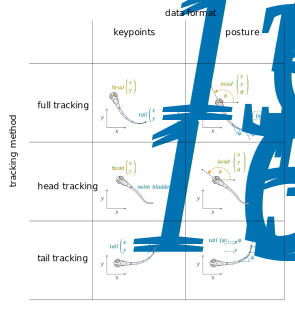

In [45]:
display(SVG(filename='megabouts_tracking_configuration.svg'))


### Loading Example Data

The `load_example_data` function allows to load example `.csv` dataset corresponding to several tracking configuration (`fulltracking_posture`, `SLEAP_fulltracking`, `HR_DLC`, `zebrabox_SLEAP`). In the following sections we  demonstrates how to import the example dataset into the `TrackingData` class.

## Example of high-resolution tracking for freely-swimming zebrafish

In [31]:
df_recording, fps, mm_per_unit = load_example_data('fulltracking_posture')
df_recording.head(5)

,head_x,head_y,head_angle,tail_angle_0,tail_angle_1,tail_angle_2,tail_angle_3,tail_angle_4,tail_angle_5,tail_angle_6,tail_angle_7,tail_angle_8,tail_angle_9
0,-22.979468,3.989994,-2.218813,-0.101865,-0.092813,-0.107645,-0.110575,-0.047699,-0.145887,-0.130414,-0.058892,-0.128705,NaN
1,-22.977063,3.998453,-2.225990,-0.082618,-0.087957,-0.096951,-0.092459,-0.119418,-0.043354,-0.099788,-0.101741,-0.171555,NaN
2,-22.978636,3.993386,-2.221900,-0.093377,-0.095235,-0.094292,-0.105936,-0.073785,-0.084193,-0.144378,-0.112398,-0.042585,NaN
3,-22.981788,3.992900,-2.223969,-0.092590,-0.083650,-0.100938,-0.088223,-0.097370,-0.099559,-0.101538,-0.091272,-0.021459,NaN
4,-22.977184,3.999899,-2.226333,-0.086849,-0.081982,-0.096705,-0.118475,-0.046264,-0.136459,-0.115412,-0.085300,-0.015487,NaN


* We first define the tracking configuration given the framerate and tracking method:

In [12]:
tracking_cfg = TrackingConfig(fps=fps, tracking='full_tracking')

* We first extract the posture from the `df_recording` dataframe and convert position to mm


In [13]:
head_x = df_recording['head_x'].values*mm_per_unit
head_y = df_recording['head_y'].values*mm_per_unit
head_yaw = df_recording['head_angle'].values
tail_angle = df_recording.filter(like='tail_angle').values

* Finally we input the postural array into the `FullTrackingData` class:

In [14]:
tracking_data = FullTrackingData.from_posture(head_x = head_x,
                                              head_y = head_y,
                                              head_yaw = head_yaw,
                                              tail_angle = tail_angle)

* We can use the dataframe `tracking_data.tail_df` and `tracking_data.traj_df` to visualize the tail and head trajectory

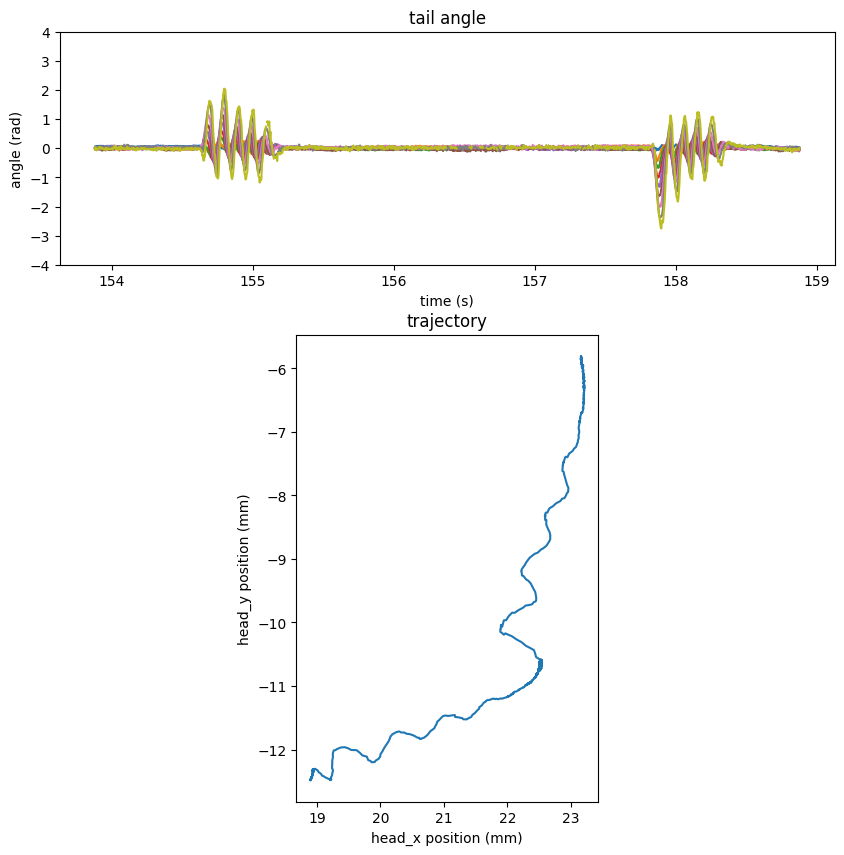

In [20]:
t = np.arange(tracking_data.T)/tracking_cfg.fps
IdSt = np.random.randint(tracking_data.T)
Duration = 5*tracking_cfg.fps

fig,ax = plt.subplots(2,1,figsize=(10,10),height_ratios=[0.5,1])
ax[0].plot(t[IdSt:IdSt+Duration],tracking_data.tail_df.iloc[IdSt:IdSt+Duration,:])
ax[0].set(title='tail angle',xlabel='time (s)',ylabel='angle (rad)',ylim=(-4,4))

ax[1].plot(tracking_data.traj_df.x.iloc[IdSt:IdSt+Duration],
           tracking_data.traj_df.y.iloc[IdSt:IdSt+Duration])
ax[1].set(title='trajectory',aspect='equal',xlabel='head_x position (mm)',ylabel='head_y position (mm)')
plt.show()

## Example of tail tracking in head-restrained condition

* The following example correspond to tail tracking using DeepLabCut at 250fps.

In [16]:
df_recording, fps, mm_per_unit = load_example_data('HR_DLC')
df_recording = df_recording['DLC_resnet50_Zebrafish']
df_recording.head(5)

head_rostral                      head_caudal                        \
             x         y likelihood           x          y likelihood   
0   173.163055  2.995913   0.999985  177.695465  40.429813   0.999986   
1   172.605087  2.485497   0.999978  177.292572  40.164856   0.999983   
2   172.442398  2.889864   0.999985  176.992661  40.337017   0.999978   
3   173.055008  3.141099   0.999988  177.103790  40.811363   0.999983   
4   172.497513  3.288911   0.999988  176.927582  40.711155   0.999981   

        tail0                             tail1  ...      tail7       tail8  \
            x          y likelihood           x  ... likelihood           x   
0  180.415710  80.903931   0.999986  180.984070  ...   0.999699  176.853455   
1  180.129837  80.911896   0.999986  180.985275  ...   0.999701  176.757172   
2  179.854385  81.170639   0.999989  180.823120  ...   0.999689  176.803375   
3  179.919678  81.260208   0.999992  180.836472  ...   0.999672  176.752884   
4  179.895370  81.267540   0.999990  180.830780  ...   0.999690  176.760941   

                               tail9                             tail10  \
            y likelihood           x           y likelihood           x   
0  255.031494   0.999377  177.243164  275.275574   0.999759  182.846207   
1  254.480911   0.999264  177.075943  274.513336   0.999753  181.680435   
2  254.154663   0.999175  177.024689  274.277985   0.999738  181.801056   
3  253.947128   0.999102  176.918564  274.054047   0.999732  181.057159   
4  254.114883   0.999147  176.989029  274.209351   0.999724  181.283981   

                          
            y likelihood  
0  295.142303   0.998607  
1  294.865326   0.998829  
2  294.448608   0.998983  
3  294.441162   0.999080  
4  294.534668   0.999020  

[5 rows x 39 columns]

* We first define the tracking configuration given the framerate and tracking method:

In [17]:
tracking_cfg = TrackingConfig(fps=fps, tracking='tail_tracking')

* We will place nan on the tail keypoints coordinate when the likelihood is below a threshold

In [18]:
kpts_list = [f'tail{i}' for i in range(11)]
thresh_score = 0.99
for kps in kpts_list:
    df_recording.loc[df_recording[(kps,'likelihood')] < thresh_score, (kps, 'x')] = np.nan
    df_recording.loc[df_recording[(kps,'likelihood')] < thresh_score, (kps, 'y')] = np.nan

* We extract the tail keypoints coordinate and convert them in millimeters:

In [19]:
tail_x = df_recording.loc[:, [(segment, 'x') for segment, coord in df_recording.columns if segment in kpts_list and coord == 'x']].values
tail_y = df_recording.loc[:, [(segment, 'y') for segment, coord in df_recording.columns if segment in kpts_list and coord == 'y']].values

tail_x = tail_x*mm_per_unit
tail_y = tail_y*mm_per_unit

* Finally we input the postural array into the `TailTrackingData` class:

In [14]:
tracking_data = TailTrackingData.from_keypoints(tail_x = tail_x,                                                
                                                tail_y = tail_y)

* We can use the dataframe `tracking_data.tail_df` to visualize the tail angle

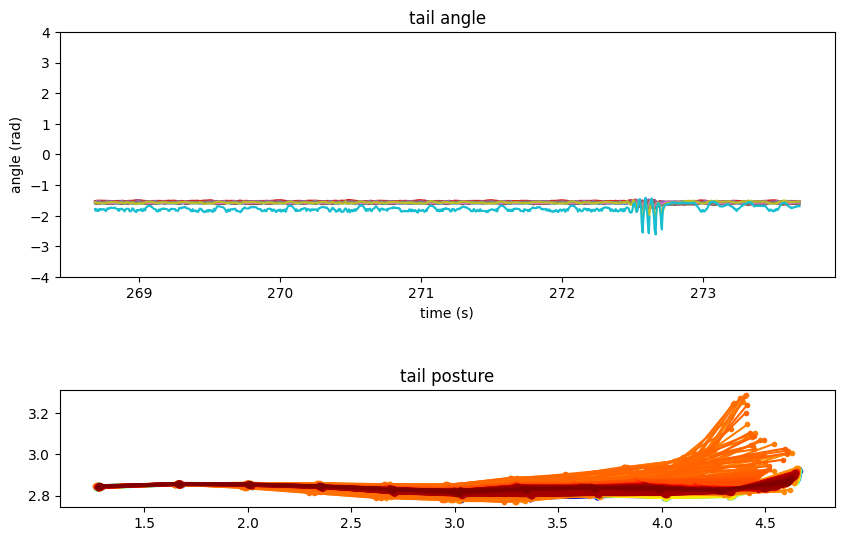

In [15]:
t = np.arange(tracking_data.T)/tracking_cfg.fps
IdSt = np.random.randint(tracking_data.T)
Duration = 5*tracking_cfg.fps

fig,ax = plt.subplots(2,1,figsize=(10,7),height_ratios=[1,1])
ax[0].plot(t[IdSt:IdSt+Duration],tracking_data.tail_df.iloc[IdSt:IdSt+Duration,:])
ax[0].set(title='tail angle', ylim=[-4,4], xlabel='time (s)',ylabel ='angle (rad)')

cmap = plt.get_cmap('jet')
for i in range(IdSt,IdSt+Duration):
    ax[1].plot(tracking_data._tail_y[i,:],tracking_data._tail_x[i,:],'.-',color = cmap((i-IdSt)/Duration))
ax[1].set(title='tail posture',aspect='equal')

plt.show()

## Example of low resolution centroid tracking from the Zebrabox config

* The following example correspond to head and swim-bladder tracking using SLEAP on video data from the Zebrabox system.

In [16]:
df_recording, fps, mm_per_unit = load_example_data('zebrabox_SLEAP')
df_recording.head(5)

,track,frame_idx,instance.score,swim_bladder.x,swim_bladder.y,swim_bladder.score,mid_eye.x,mid_eye.y,mid_eye.score
0,NaN,0,0.732962,111.594383,122.333862,0.834701,120.034706,118.537903,0.827217
1,NaN,1,0.733804,111.594688,122.324165,0.834202,120.029968,118.541588,0.826500
2,NaN,2,0.734254,111.595268,122.321350,0.834111,120.029823,118.539879,0.826383
3,NaN,3,0.732529,111.611320,122.310394,0.831942,120.030312,118.545074,0.827309
4,NaN,4,0.733020,111.588501,122.294258,0.832367,120.054565,118.565849,0.820087


* We first define the tracking configuration given the framerate and tracking method:

In [17]:
tracking_cfg = TrackingConfig(fps=fps, tracking='head_tracking')

* We will place nan on the keypoints coordinate when the score is below a threshold

In [18]:
thresh_score = 0.75
is_tracking_bad = (df_recording['swim_bladder.score'] < thresh_score) | (df_recording['mid_eye.score'] < thresh_score)
df_recording.loc[is_tracking_bad,'mid_eye.x'] = np.nan
df_recording.loc[is_tracking_bad,'mid_eye.y'] = np.nan
df_recording.loc[is_tracking_bad,'swim_bladder.x'] = np.nan
df_recording.loc[is_tracking_bad,'swim_bladder.y'] = np.nan

* We extract the head and swim bladder keypoints coordinate and convert them in millimeters:

In [19]:
head_x = df_recording['mid_eye.x'].values*mm_per_unit
head_y = df_recording['mid_eye.y'].values*mm_per_unit
swimbladder_x = df_recording['swim_bladder.x'].values*mm_per_unit
swimbladder_y = df_recording['swim_bladder.y'].values*mm_per_unit

* Finally we input the keypoints into the `HeadTrackingData` class:

In [20]:
tracking_data = HeadTrackingData.from_keypoints(head_x = head_x,  
                                                head_y = head_y,  
                                                swimbladder_x = swimbladder_x,                                                
                                                swimbladder_y = swimbladder_y)

* We can use the dataframe `tracking_data.traj_df` to visualize the head position and yaw

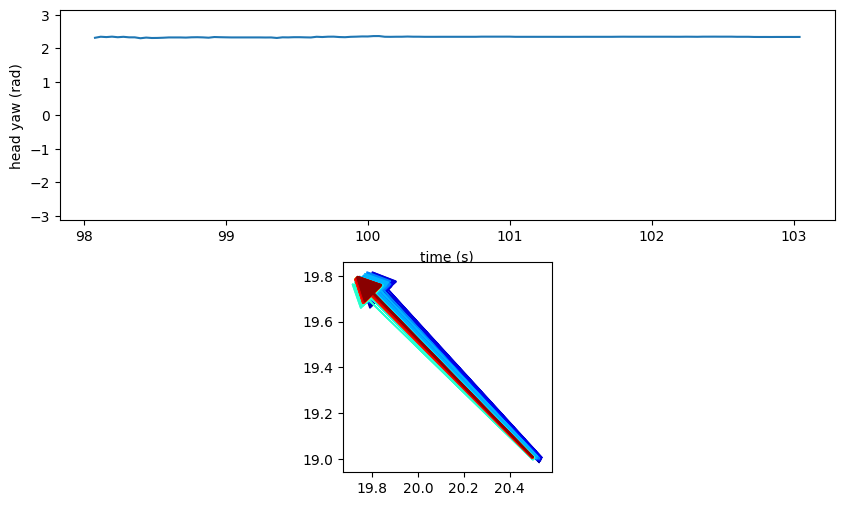

In [21]:
t = np.arange(tracking_data.T)/tracking_cfg.fps
IdSt = np.random.randint(tracking_data.T)
Duration = 5*tracking_cfg.fps

fig,ax = plt.subplots(2,1,figsize=(10,6),height_ratios=[1,1])
ax[0].plot(t[IdSt:IdSt+Duration],tracking_data.traj_df['yaw'].iloc[IdSt:IdSt+Duration])
ax[0].set(xlabel='time (s)',ylabel='head yaw (rad)',ylim=(-np.pi,np.pi))

cmap = plt.get_cmap('jet')
for i in range(IdSt,IdSt+Duration):
    ax[1].arrow(tracking_data.traj_df['x'][i],
                 tracking_data.traj_df['y'][i],
                 np.cos(tracking_data.traj_df['yaw'][i]),
                 np.sin(tracking_data.traj_df['yaw'][i]),
                 head_width=.1, head_length=.1,color = cmap((i-IdSt)/Duration) )
ax[1].set_aspect('equal')
plt.show()

## Example of noisy tracking of freely-swimming zebrafish

* The following example correspond to full tracking at 350fps. The fish posture is tracked using SLEAP but the keypoints are not reliably placed due to insufficient labelling.

In [22]:
df_recording, fps, mm_per_unit = load_example_data('SLEAP_fulltracking')
df_recording.head(5)

,track,frame_idx,instance.score,left_eye.x,left_eye.y,left_eye.score,right_eye.x,right_eye.y,right_eye.score,tail0.x,...,tail1.score,tail2.x,tail2.y,tail2.score,tail3.x,tail3.y,tail3.score,tail4.x,tail4.y,tail4.score
0,NaN,0,0.977651,822.667358,839.635101,0.988699,807.832947,840.091492,0.953313,813.303932,...,0.987229,807.466705,767.853134,1.027914,806.901657,747.167450,0.941431,803.414474,730.643631,0.821148
1,NaN,1,0.977400,822.669495,839.644699,0.988768,807.837723,840.099838,0.951950,813.305016,...,0.987644,807.468445,767.856720,1.027526,806.901627,747.176315,0.941242,803.420502,730.653046,0.822505
2,NaN,2,0.977176,822.668884,839.653854,0.988344,807.838104,840.107727,0.950716,813.306580,...,0.987669,807.469040,767.860291,1.027348,806.905151,747.177567,0.941105,803.416382,730.654694,0.820525
3,NaN,3,0.976941,822.670547,839.665436,0.989196,810.813538,840.147018,0.950221,813.307747,...,0.988717,807.468109,767.858276,1.026542,806.905106,747.178329,0.940126,803.417862,730.658585,0.820215
4,NaN,4,0.976689,822.674286,839.674667,0.989967,810.819382,840.155060,0.949718,813.308144,...,0.989073,807.468567,767.867950,1.026512,806.904449,747.200958,0.940060,803.418640,730.675385,0.824549


* We first define the tracking configuration given the framerate and tracking method:

In [23]:
tracking_cfg = TrackingConfig(fps=fps, tracking='full_tracking')

* We will place nan on the keypoints coordinate when the score is below a threshold

In [24]:
# Place nan where the score is below a threshold:
thresh_score = 0.
for kps in ['left_eye','right_eye','tail0','tail1','tail2','tail3','tail4']:
    df_recording.loc[df_recording['instance.score']<thresh_score,kps+'.x'] = np.nan
    df_recording.loc[df_recording['instance.score']<thresh_score,kps+'.y'] = np.nan
    df_recording.loc[df_recording[kps+'.score']<thresh_score,kps+'.x'] = np.nan
    df_recording.loc[df_recording[kps+'.score']<thresh_score,kps+'.y'] = np.nan
    

* We extract the head and tail keypoints coordinate and convert them in millimeters:

In [25]:
head_x = (df_recording['left_eye.x'].values+df_recording['right_eye.x'].values)/2
head_y = (df_recording['left_eye.y'].values+df_recording['right_eye.y'].values)/2

tail_x = df_recording[['tail0.x','tail1.x','tail2.x','tail3.x','tail4.x']].values
tail_y = df_recording[['tail0.y','tail1.y','tail2.y','tail3.y','tail4.y']].values

head_x = head_x*mm_per_unit
head_y = head_y*mm_per_unit
tail_x = tail_x*mm_per_unit
tail_y = tail_y*mm_per_unit

* Finally we keypoints array are loaded into the `FullTrackingData` class:

In [26]:
tracking_data = FullTrackingData.from_keypoints(head_x = head_x,
                                                head_y = head_y,
                                                tail_x = tail_x,                                                
                                                tail_y = tail_y)

* We can use the dataframe `tracking_data.tail_df` and `tracking_data.traj_df` to visualize the fish posture.

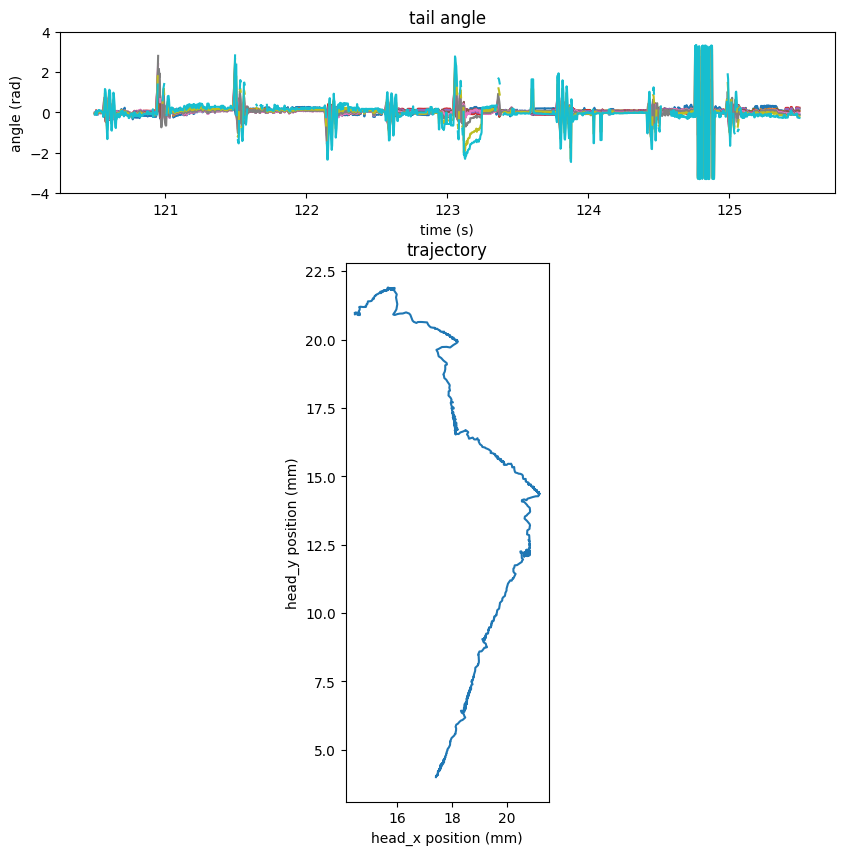

In [27]:
t = np.arange(tracking_data.T)/tracking_cfg.fps
IdSt = np.random.randint(tracking_data.T)
Duration = 5*tracking_cfg.fps

fig,ax = plt.subplots(2,1,figsize=(10,10),height_ratios=[0.3,1])
ax[0].plot(t[IdSt:IdSt+Duration],tracking_data.tail_df.iloc[IdSt:IdSt+Duration,:])
ax[0].set(title='tail angle',xlabel='time (s)',ylabel='angle (rad)',ylim=(-4,4))

ax[1].plot(tracking_data.traj_df.x.iloc[IdSt:IdSt+Duration],
           tracking_data.traj_df.y.iloc[IdSt:IdSt+Duration])
ax[1].set(title='trajectory',aspect='equal',xlabel='head_x position (mm)',ylabel='head_y position (mm)')
plt.show()